# Integrating flux solutions with a SVG fluxmap

## Nitrogen assimilation metabolism

### Imports

In [1]:
import sys
from cobra.io import read_sbml_model
sys.path.append("../Code")
from model_functions import *
from cobra import flux_analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
import math
from lxml import etree

### Reading and preparing the $C_{4}$ model

In [2]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("../Models/c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[M]_Maize_biomass_tx'

#Setting up Rubisco carboxylase/oxygenase (3:1) ratio in C4 model
const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

#Block Mesophyll and Bundle Sheath "External" Rubisco
set_bounds("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p", (0,0), c4_model)
set_bounds("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex", (0,0), c4_model)


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


### Flux Integration

#### Without implementation of volume constraint

In [3]:
"""
Model simulation (autotrofic) with pFBA

Generation of a solution frame with resulting fluxes
"""

with c4_model:
    c4_model.objective = "[M]_Maize_biomass_tx"
    c4_model.solver = "glpk"
    medium = c4_model.medium
    medium["[M]_CO2_tx"] = 40   #CO2 Uptake constrain
    medium["[B]_Nitrate_tx"] = 1000 #Nitrate uptake constrain
    c4_model.medium = medium

    #Volume Constrains
    volume_ratio = 1

    #Light Uptake
    light = 700
    light_ratio = 0.66
    
    set_bounds("[M]_Photon_tx", ((light/(light_ratio+1)), light/(light_ratio+1)), c4_model)
    set_bounds("[B]_Photon_tx", ((abs(light-(light/(light_ratio+1))))/volume_ratio, (abs(light-(light/(light_ratio+1))))/volume_ratio), c4_model)


    for reaction in c4_model.reactions:
        if reaction.id[0:4] == "[MB]":
            dict = {reaction.products[0] : -(1/volume_ratio)}
            reaction.subtract_metabolites(dict, combine=False)

    solution = flux_analysis.pfba(c4_model)
    solution_frame=solution.to_frame()


In [4]:
"""Match Path and reaction names"""

match_dict = {"path6244-1-2-7-6" : "[M]_NITRATE_REDUCTASE_NADH_RXN_c",
              "path6244-1-2-7-9-36" : "[M]_NITRITE_pc"  ,
              "path6244-1-2-7-9-36-3" : "[M]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p",
              "path6000-29" : "[M]_GLUTAMINESYN_RXN_p",
              "path6244-1" : "[M]_GLUTAMINESYN_RXN_p",
              "path6000-2-3" : "[M]_GLUTAMINESYN_RXN_p",
              "path6276-9" : "[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p",
              "path6276-1-4" :"[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p",
              "path6244-1-2-7-9-3-1" :"[M]_NH3_pc",
              "path6244-1-2-7" : "[MB]_NITRATE_c",
              "path6244-1-2-7-3" : "[MB]_NITRITE_c",
              "path6244-1-2-7-3-67":"[MB]_GLT_c",
              "path6244-1-2-7-3-67-3":"[MB]_GLN_c",
              "path6244-1-2-7-3-67-3-0":"[MB]_AMMONIUM_c",
              "path6244-1-2" : "[B]_Nitrate_tx",
              "path6244-1-2-7-6-6" : "[B]_NITRATE_REDUCTASE_NADH_RXN_c",
              "path6244-1-2-7-9-3" : "[B]_NITRITE_pc",
              "path6244-1-2-7-9-3-2" : "[B]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p",
              "path6000" : "[B]_GLUTAMINESYN_RXN_p",
              "path6244" : "[B]_GLUTAMINESYN_RXN_p",
              "path6000-2" : "[B]_GLUTAMINESYN_RXN_p",
              "path6276" : "[B]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p",
              "path6276-1" :"[B]_GLUTAMATE_SYNTHASE_NADH_RXN_p",
              "path6244-1-2-7-9-36-3-2" :"[B]_GLUTAMATE_DEHYDROGENASE_RXN_m",
              "path6244-1-2-7-9-36-3-2-2" :"[B]_GCVMULTI_RXN_m",
              }

match_df = pd.DataFrame(match_dict.items(), columns=["path", "reaction_id"])
match_df

,path,reaction_id
0,path6244-1-2-7-6,[M]_NITRATE_REDUCTASE_NADH_RXN_c
1,path6244-1-2-7-9-36,[M]_NITRITE_pc
2,path6244-1-2-7-9-36-3,[M]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p
3,path6000-29,[M]_GLUTAMINESYN_RXN_p
4,path6244-1,[M]_GLUTAMINESYN_RXN_p
5,path6000-2-3,[M]_GLUTAMINESYN_RXN_p
6,path6276-9,[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p
7,path6276-1-4,[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p
8,path6244-1-2-7-9-3-1,[M]_NH3_pc
9,path6244-1-2-7,[MB]_NITRATE_c


In [5]:
path_fluxes = []

for i in range(len(list(match_dict.keys()))):
    if "[B]" in list(match_dict.values())[i]:
        path_fluxes.append(solution_frame.loc[list(match_dict.values())[i] ,"fluxes"])
    else:
        path_fluxes.append(solution_frame.loc[list(match_dict.values())[i] ,"fluxes"] / volume_ratio )

def eval_sign(i):
    if i >= 0:
        return 1
    else:
        return -1

sign = [eval_sign(i) for i in path_fluxes]

#Normalization - Max-Min normalization
path_fluxes_series = abs(pd.Series(list(path_fluxes)))
norm_path_fluxes = (path_fluxes_series-path_fluxes_series.min())/(path_fluxes_series.max()-path_fluxes_series.min())

match_df = match_df.assign(flux_values = norm_path_fluxes, signal = sign)
match_df

,path,reaction_id,flux_values,signal
0,path6244-1-2-7-6,[M]_NITRATE_REDUCTASE_NADH_RXN_c,0.708517,1
1,path6244-1-2-7-9-36,[M]_NITRITE_pc,0.708517,1
2,path6244-1-2-7-9-36-3,[M]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p,0.708517,1
3,path6000-29,[M]_GLUTAMINESYN_RXN_p,1.000000,1
4,path6244-1,[M]_GLUTAMINESYN_RXN_p,1.000000,1
5,path6000-2-3,[M]_GLUTAMINESYN_RXN_p,1.000000,1
6,path6276-9,[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p,0.982607,1
7,path6276-1-4,[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p,0.000000,1
8,path6244-1-2-7-9-3-1,[M]_NH3_pc,0.278689,-1
9,path6244-1-2-7,[MB]_NITRATE_c,0.708517,-1


c:\Anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


,path,reaction_id,flux_values,signal,colors,SQ_flux_values
0,path6244-1-2-7-6,[M]_NITRATE_REDUCTASE_NADH_RXN_c,0.708517,1,#b54aff,41.379845
1,path6244-1-2-7-9-36,[M]_NITRITE_pc,0.708517,1,#b54aff,41.379845
2,path6244-1-2-7-9-36-3,[M]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p,0.708517,1,#b54aff,41.379845
3,path6000-29,[M]_GLUTAMINESYN_RXN_p,1.000000,1,#ff00ff,44.459639
4,path6244-1,[M]_GLUTAMINESYN_RXN_p,1.000000,1,#ff00ff,44.459639
5,path6000-2-3,[M]_GLUTAMINESYN_RXN_p,1.000000,1,#ff00ff,44.459639
6,path6276-9,[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p,0.982607,1,#fb04ff,44.289666
7,path6276-1-4,[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p,0.000000,1,#00ffff,25.000000
8,path6244-1-2-7-9-3-1,[M]_NH3_pc,0.278689,-1,#47b8ff,35.272930
9,path6244-1-2-7,[MB]_NITRATE_c,0.708517,-1,#b54aff,41.379845


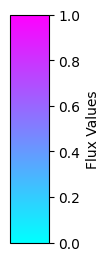

In [6]:
"""Create color gradient"""


def b_g(cmap='cool', low=0, high=0, dataframe = match_df):
    a = pd.Series(list(dataframe["flux_values"]))
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]

    ###- Trying to get that sweet colorbar
    fig, ax = plt.subplots(figsize=(.5, 6))
    fig.subplots_adjust(bottom=0.5)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    cb1.set_label('Flux Values')
    fig.show()
    fig.savefig('../Images/SVG_Colorbar.svg', format='svg', bbox_inches = 'tight')

    grad = [color for color in c]
    return grad

match_df["colors"] = b_g(dataframe=match_df)

#Normalization - square root transformation - Arrow Width
path_fluxes = list(path_fluxes)
norm_path_fluxes = [(0.5 + 0.2 * math.sqrt(abs(i))) * 50 for i in path_fluxes]

match_df = match_df.assign(SQ_flux_values = norm_path_fluxes)
match_df

In [7]:
"""Parse the SVG"""

def parser(filename = r"../Images/N_Metabolism_NoVRatio.svg", path = "path229", fill = "#ff0000", width = 1, signal = 1):
    tree = etree.parse(open(filename, 'r'))
    if signal == 1:
        for element in tree.iter():
            if element.tag.split("}")[1] == "path":
                if element.get("id") == path:
                    element.set("style", f"clip-rule:evenodd;fill:none;fill-rule:evenodd;stroke:{fill} ;stroke-width:{round(width,2)};stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;marker-end:url(#Arrow1);image-rendering:optimizeQuality;shape-rendering:geometricPrecision;text-rendering:geometricPrecision")
            else:
                pass
    else:
        for element in tree.iter():
            if element.tag.split("}")[1] == "path":
                if element.get("id") == path:
                    element.set("style", f"clip-rule:evenodd;fill:none;fill-rule:evenodd;stroke:{fill};stroke-width:{round(width,2)};stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;image-rendering:optimizeQuality;shape-rendering:geometricPrecision;text-rendering:geometricPrecision;marker-start:url(#Arrow1)")
            else:
                pass

    tree.write(filename)


for i in range(len(match_df["flux_values"])):
    parser(path = list(match_df["path"])[i], fill = list(match_df["colors"])[i], width= list(match_df["SQ_flux_values"])[i], signal = list(match_df["signal"])[i])



#### With implementation of volume constraint

In [8]:
"""
Model simulation (autotrofic) with pFBA

Generation of a solution frame with resulting fluxes
"""

with c4_model:
    c4_model.objective = "[M]_Maize_biomass_tx"
    c4_model.solver = "glpk"
    medium = c4_model.medium
    medium["[M]_CO2_tx"] = 40   #CO2 Uptake constrain
    medium["[B]_Nitrate_tx"] = 1000 #Nitrate uptake constrain
    c4_model.medium = medium

    #Volume Constrains
    volume_ratio = 5.3

    #Light Uptake
    light = 700
    light_ratio = 0.66
    
    set_bounds("[M]_Photon_tx", ((light/(light_ratio+1)), light/(light_ratio+1)), c4_model)
    set_bounds("[B]_Photon_tx", ((abs(light-(light/(light_ratio+1))))/volume_ratio, (abs(light-(light/(light_ratio+1))))/volume_ratio), c4_model)


    for reaction in c4_model.reactions:
        if reaction.id[0:4] == "[MB]":
            dict = {reaction.products[0] : -(1/volume_ratio)}
            reaction.subtract_metabolites(dict, combine=False)

    solution = flux_analysis.pfba(c4_model)
    solution_frame=solution.to_frame()


In [9]:

"""Match Path and reaction names"""

match_dict = {"path6244-1-2-7-6" : "[M]_NITRATE_REDUCTASE_NADH_RXN_c",
              "path6244-1-2-7-9-36" : "[M]_NITRITE_pc"  ,
              "path6244-1-2-7-9-36-3" : "[M]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p",
              "path6000-29" : "[M]_GLUTAMINESYN_RXN_p",
              "path6244-1" : "[M]_GLUTAMINESYN_RXN_p",
              "path6000-2-3" : "[M]_GLUTAMINESYN_RXN_p",
              "path6276-9" : "[M]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p",
              "path6276-1-4" :"[M]_GLUTAMATE_SYNTHASE_NADH_RXN_p",
              "path6244-1-2-7-9-3-1" :"[M]_NH3_pc",
              "path6244-1-2-7" : "[MB]_NITRATE_c",
              "path6244-1-2-7-3" : "[MB]_NITRITE_c",
              "path6244-1-2-7-3-67":"[MB]_GLT_c",
              "path6244-1-2-7-3-67-3":"[MB]_GLN_c",
              "path6244-1-2-7-3-67-3-0":"[MB]_AMMONIUM_c",
              "path6244-1-2" : "[B]_Nitrate_tx",
              "path6244-1-2-7-6-6" : "[B]_NITRATE_REDUCTASE_NADH_RXN_c",
              "path6244-1-2-7-9-3" : "[B]_NITRITE_pc",
              "path6244-1-2-7-9-3-2" : "[B]_FERREDOXIN_NITRITE_REDUCTASE_RXN_p",
              "path6000" : "[B]_GLUTAMINESYN_RXN_p",
              "path6244" : "[B]_GLUTAMINESYN_RXN_p",
              "path6000-2" : "[B]_GLUTAMINESYN_RXN_p",
              "path6276" : "[B]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p",
              "path6276-1" :"[B]_GLUTAMATE_SYNTHASE_NADH_RXN_p",
              "path6244-1-2-7-9-36-3-2" :"[B]_GLUTAMATE_DEHYDROGENASE_RXN_m",
              "path6244-1-2-7-9-36-3-2-2" :"[B]_GCVMULTI_RXN_m",
              }

match_df = pd.DataFrame(match_dict.items(), columns=["path", "reaction_id"])

In [10]:

path_fluxes = []

for i in range(len(list(match_dict.keys()))):
    if "[B]" in list(match_dict.values())[i]:
        path_fluxes.append(solution_frame.loc[list(match_dict.values())[i] ,"fluxes"])
    else:
        path_fluxes.append(solution_frame.loc[list(match_dict.values())[i] ,"fluxes"] / volume_ratio )

def eval_sign(i):
    if i >= 0:
        return 1
    else:
        return -1

sign = [eval_sign(i) for i in path_fluxes]

#Normalization - Max-Min normalization
path_fluxes_series = abs(pd.Series(list(path_fluxes)))
norm_path_fluxes = (path_fluxes_series-path_fluxes_series.min())/(path_fluxes_series.max()-path_fluxes_series.min())

match_df = match_df.assign(flux_values = norm_path_fluxes, signal = sign)


c:\Anaconda\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


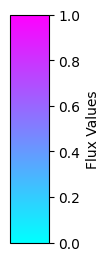

In [11]:

"""Create color gradient"""


def b_g(cmap='cool', low=0, high=0, dataframe = match_df):
    a = pd.Series(list(dataframe["flux_values"]))
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]

    ###- Trying to get that sweet colorbar
    fig, ax = plt.subplots(figsize=(.5, 6))
    fig.subplots_adjust(bottom=0.5)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    cb1.set_label('Flux Values')
    fig.show()
    fig.savefig('../Images/SVG_Colorbar.svg', format='svg', bbox_inches = 'tight')

    grad = [color for color in c]
    return grad

match_df["colors"] = b_g(dataframe=match_df)

#Normalization - square root transformation - Arrow Width
path_fluxes = list(path_fluxes)
norm_path_fluxes = [(0.5 + 0.2 * math.sqrt(abs(i))) * 50 for i in path_fluxes]

match_df = match_df.assign(SQ_flux_values = norm_path_fluxes)


In [12]:

"""Parse the SVG"""

def parser(filename = r"../Images/N_Metabolism_VRatio.svg", path = "path229", fill = "#ff0000", width = 1, signal = 1):
    tree = etree.parse(open(filename, 'r'))
    if signal == 1:
        for element in tree.iter():
            if element.tag.split("}")[1] == "path":
                if element.get("id") == path:
                    element.set("style", f"clip-rule:evenodd;fill:none;fill-rule:evenodd;stroke:{fill} ;stroke-width:{round(width,2)};stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;marker-end:url(#Arrow1);image-rendering:optimizeQuality;shape-rendering:geometricPrecision;text-rendering:geometricPrecision")
            else:
                pass
    else:
        for element in tree.iter():
            if element.tag.split("}")[1] == "path":
                if element.get("id") == path:
                    element.set("style", f"clip-rule:evenodd;fill:none;fill-rule:evenodd;stroke:{fill};stroke-width:{round(width,2)};stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-opacity:1;image-rendering:optimizeQuality;shape-rendering:geometricPrecision;text-rendering:geometricPrecision;marker-start:url(#Arrow1)")
            else:
                pass

    tree.write(filename)


for i in range(len(match_df["flux_values"])):
    parser(path = list(match_df["path"])[i], fill = list(match_df["colors"])[i], width= list(match_df["SQ_flux_values"])[i], signal = list(match_df["signal"])[i])

